In [1]:
import logging

import pickle

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints
from torch import nn
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive
import seaborn as sns
from pyro import poutine
from sklearn import metrics

In [2]:
pyro.set_rng_seed(10)

In [3]:
class PMF(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, data, train, dim):
        super().__init__()
        """Build the Probabilistic Matrix Factorization model using pymc3.



        """
        self.dim = dim   
        self.data = data.copy()
        self.n, self.m = self.data.shape
        self.map = None
        self.bounds = (0,1)
        self.losses = None
        self.predictions = None
        self.returned = None
        self.predictive_svi = None


        # Perform mean value imputation
    
        
        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = (np.mean(self.data, axis=1).mean())**2 / np.std(self.data, axis=1).mean()
        self.alpha_v = (np.mean(self.data, axis=0).mean())**2 / np.std(self.data, axis=0).mean()
        
        self.beta_u = (np.mean(self.data, axis=1).mean()) / np.std(self.data, axis=1).mean()
        self.beta_v = (np.mean(self.data, axis=0).mean()) / np.std(self.data, axis=0).mean()
        self.bias = self.data.mean()


    def model(self, train, mask):
     

        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

        with drug_plate: 
            UA = pyro.sample("UA", dist.Gamma(self.alpha_u, self.beta_u).expand([self.dim]).to_event(1))
            #UA_int = pyro.sample("UAint", dist.Normal(0., 1.))
        
        with sideeffect_plate:
            VA = pyro.sample("VA", dist.Gamma(self.alpha_v, self.beta_v).expand([self.dim]).to_event(1))
            #possibly add intercepts VA_int = pyro.sample("VA", dist.Normal(0., 1.).to_event(1))
       
        u2_plate = pyro.plate("u2_plate", self.n, dim=-2)

        with sideeffect_plate, u2_plate: 
            with pyro.poutine.mask(mask=mask):
             Y = pyro.sample("target", dist.Poisson(UA@VA.T), obs=train ) 
             return Y
        

    def guide(self, train=None, mask=None):

        d_alpha = pyro.param('d_alpha', torch.ones(self.n,self.dim), constraint=constraints.positive)#*self.user_mean)
        d_beta = pyro.param('d_beta', 0.5*torch.ones(self.n,self.dim), constraint=constraints.positive)
       # int_mean = pyro.param('int_mean', torch.tensor(1.)*self.user_mean)
       # mov_cov = pyro.param('mov_cov', torch.tensor(1.)*0.1,
          #                  constraint=constraints.positive)

        s_alpha = pyro.param('s_alpha', torch.ones(self.m,self.dim), constraint=constraints.positive)#*self.item_mean)
        s_beta = pyro.param('s_beta', 0.5*torch.ones(self.m,self.dim), constraint=constraints.positive)
        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

        with drug_plate: 
            UA = pyro.sample("UA", dist.Gamma(d_alpha, d_beta).to_event(1))
           # UA_int = pyro.sample("UAint", dist.Normal(int_mean, mov_cov).to_event(1))
        with sideeffect_plate: 
            VA = pyro.sample("VA", dist.Gamma(s_alpha, s_beta).to_event(1))
    
    def train_SVI(self,train,mask, nsteps=500, lr = 0.05, lrd = 1, verbose=True):
        logging.basicConfig(format='%(message)s', level=logging.INFO)
        svi = SVI(self.model,
        self.guide,
        optim.ClippedAdam({"lr": lr, "lrd": lrd}),
        loss=Trace_ELBO())
        losses = []
        for step in range(nsteps):
            elbo = svi.step(torch.from_numpy(train).float(), mask)
            losses.append(elbo)
            if(verbose):
                if step % 10 == 0:
                    print("Elbo loss: {}".format(elbo))
        self.losses = losses
        #constrained_params = list(pyro.get_param_store().values())
        #PARAMS = [p.unconstrained() for p in constrained_params]
        #print(PARAMS)
        return losses
    
    def sample_predict(self, nsamples=500 , verbose=True):
        unmasked =torch.ones((self.n,self.m), dtype=torch.bool)
        predictive_svi = Predictive(self.model, guide=self.guide, num_samples=nsamples)(None , unmasked)
        if (verbose):
            for k, v in predictive_svi.items():
                print(f"{k}: {tuple(v.shape)}")
        table = predictive_svi["target"].numpy()
        self.predictive_svi = predictive_svi
        #print(table)
        self.returned = table
        mc_table = table.mean(axis = 0)
        mc_table_std = table.std(axis = 0)
     
        self.predictions = mc_table

    def predictive_score(self,test,masked):
        # total = test.shape[0]*test.shape[1]
        
        UA =  self.predictive_svi["UA"]
        VA = self.predictive_svi["VA"]
        VA = VA.mean(axis=0).reshape(self.m,self.dim)
        UA = UA.mean(axis=0).reshape(self.n,self.dim)
        print(UA.shape)
        score = dist.Poisson(UA@VA.T).log_prob(torch.from_numpy(test))
        mean_score = (score*masked).reshape(-1).logsumexp(-1) -np.log(test.shape[0]*test.shape[1])
        return mean_score
        
    
    def rmse(self,test,masked,h):
        low, high = self.bounds
        test_data = test.copy()
        test_data[test_data < h] = low
        test_data[test_data >= h] = high
        size = masked.sum()
        predictions = self.predictions
        predictions[predictions < h] = low
        predictions[predictions >= h] = high
        sqerror = abs(test_data[masked] - predictions[masked]) ** 2  # squared error array
        mse = sqerror.sum()/size
        print("PMF  RMSE: " , np.sqrt(mse))
        fpr, tpr, thresholds = metrics.roc_curve(test_data[masked].astype(int).flatten(),  predictions[masked].astype(int).flatten(), pos_label=1)
        metrics.auc(fpr, tpr)
        print("AUC: %.5f" % metrics.auc(fpr, tpr))
        return np.sqrt(mse) , metrics.auc(fpr, tpr)

    def get_predictions(self):
        return (self.returned,self.predictions)

    def get_predictive_svi(self):
         return (self.predictive_svi)

    
   
       

In [4]:

with open('data_all.pickle', 'rb') as handle:
    data = pickle.load(handle)
print(data.shape)

with open('data_train.pickle', 'rb') as handle:
    data2 = pickle.load(handle)
print(data2.shape)

nan_mask = np.isnan(data2)


(1127, 5237)
(1127, 5237)


In [5]:

def predictive_score_for_diim_estimation(data_all, train, classname):
    score=[]
    for d in [1,5,10,20,50,75,100,200,250]:
        nan_mask = np.isnan(train) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 
        test = classname(data_all,train, d)  
        pyro.clear_param_store()
        test.train_SVI(data_all , ~torch.from_numpy(nan_mask),nsteps=250, verbose = False)
        test.sample_predict(250)
        score.append(test.predictive_score(data_all,  torch.from_numpy(nan_mask)))
    return score

s = predictive_score_for_diim_estimation(data,data2, PMF)


UA: (250, 1, 1127, 1)
VA: (250, 1, 5237, 1)
target: (250, 1127, 5237)
torch.Size([1127, 1])
UA: (250, 1, 1127, 5)
VA: (250, 1, 5237, 5)
target: (250, 1127, 5237)
torch.Size([1127, 5])
UA: (250, 1, 1127, 10)
VA: (250, 1, 5237, 10)
target: (250, 1127, 5237)
torch.Size([1127, 10])
UA: (250, 1, 1127, 20)
VA: (250, 1, 5237, 20)
target: (250, 1127, 5237)
torch.Size([1127, 20])
UA: (250, 1, 1127, 50)
VA: (250, 1, 5237, 50)
target: (250, 1127, 5237)
torch.Size([1127, 50])
UA: (250, 1, 1127, 75)
VA: (250, 1, 5237, 75)
target: (250, 1127, 5237)
torch.Size([1127, 75])
UA: (250, 1, 1127, 100)
VA: (250, 1, 5237, 100)
target: (250, 1127, 5237)
torch.Size([1127, 100])
UA: (250, 1, 1127, 200)
VA: (250, 1, 5237, 200)
target: (250, 1127, 5237)
torch.Size([1127, 200])
UA: (250, 1, 1127, 250)
VA: (250, 1, 5237, 250)
target: (250, 1127, 5237)
torch.Size([1127, 250])


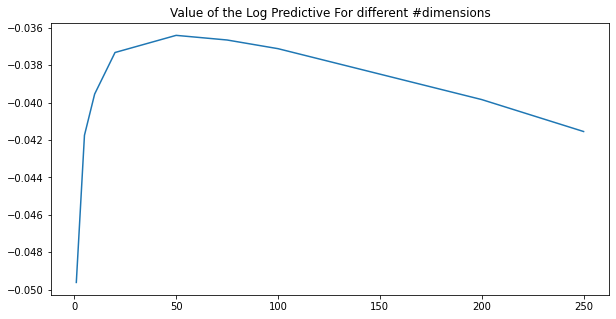

In [6]:
d = [1,5,10,20,50,75,100,200,250]
plt.figure(figsize=(10, 5))
plt.plot(d, s)
plt.title("Value of the Log Predictive For different #dimensions")
#plt.savefig("predictive_score_simple.png")
plt.show()
pyro.clear_param_store()

In [8]:
pyro.clear_param_store()
test = PMF(data, train=data, dim=50)
a = test.train_SVI(data, ~torch.from_numpy(nan_mask))


Elbo loss: 1050600503.171875
Elbo loss: 168428405.90234375
Elbo loss: 58781801.94921875
Elbo loss: 34237314.01660156
Elbo loss: 29974427.3828125
Elbo loss: 28011006.5234375
Elbo loss: 27298816.13671875
Elbo loss: 25570212.6640625
Elbo loss: 23489528.94921875
Elbo loss: 21268731.0625
Elbo loss: 19765356.4296875
Elbo loss: 18721475.875
Elbo loss: 18012337.1796875
Elbo loss: 17634014.34375
Elbo loss: 17238923.21875
Elbo loss: 16703105.6953125
Elbo loss: 16588499.265625
Elbo loss: 16331343.84375
Elbo loss: 16156457.8046875
Elbo loss: 16134131.265625
Elbo loss: 15870246.8125
Elbo loss: 15751987.671875
Elbo loss: 15788247.078125
Elbo loss: 15689071.2578125
Elbo loss: 15562534.64453125
Elbo loss: 15727343.94921875
Elbo loss: 15537864.1875
Elbo loss: 15396067.70703125
Elbo loss: 15236148.3203125
Elbo loss: 15330930.765625
Elbo loss: 15070139.84765625
Elbo loss: 15109484.92578125
Elbo loss: 14930512.43359375
Elbo loss: 15133242.8515625
Elbo loss: 15049134.98828125
Elbo loss: 15005767.8125
Elbo 

In [9]:
b = test.train_SVI(data, ~torch.from_numpy(nan_mask))

Elbo loss: 14803791.31640625
Elbo loss: 14952825.25390625
Elbo loss: 14958995.4453125
Elbo loss: 14669513.890625
Elbo loss: 14363821.171875
Elbo loss: 14558730.8984375
Elbo loss: 14336240.4296875
Elbo loss: 14719416.859375
Elbo loss: 14619763.296875
Elbo loss: 14363914.59375
Elbo loss: 14579185.7265625
Elbo loss: 14350771.234375
Elbo loss: 14510087.953125
Elbo loss: 14297841.640625
Elbo loss: 14407110.03515625
Elbo loss: 14336824.4765625
Elbo loss: 14489126.4921875
Elbo loss: 14514404.28125
Elbo loss: 14260753.65234375
Elbo loss: 14659074.25
Elbo loss: 14726783.59375
Elbo loss: 14483967.46875
Elbo loss: 14357441.265625
Elbo loss: 14364005.3125
Elbo loss: 14459271.75
Elbo loss: 14512820.37890625
Elbo loss: 14510970.89453125
Elbo loss: 14383517.640625
Elbo loss: 14091609.734375
Elbo loss: 14273885.248046875
Elbo loss: 14255741.662109375
Elbo loss: 14390470.0859375
Elbo loss: 14272098.373046875
Elbo loss: 14168874.22265625
Elbo loss: 14300978.6328125
Elbo loss: 14230149.978515625
Elbo los

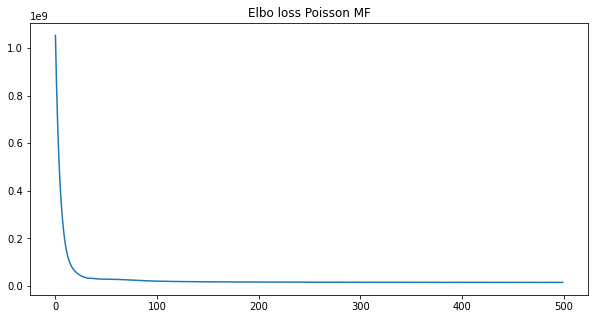

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(500), again)
plt.title("Elbo loss Poisson MF")
#plt.savefig("elbo_loss_simple_svi.png")
plt.show()
pyro.clear_param_store()

In [10]:
test.sample_predict(400)

UA: (400, 1, 1127, 50)
VA: (400, 1, 5237, 50)
target: (400, 1127, 5237)


In [11]:
#test rmse
test.rmse(data, nan_mask,1)
#train rmse
test.rmse(data, ~nan_mask,1)


PMF  RMSE:  0.35010986513971304
AUC: 0.82786
PMF  RMSE:  0.3412834045667203
AUC: 0.83408


(0.3412834045667203, 0.8340836458187948)

In [12]:
#test rmse
test.rmse(data, nan_mask,4)
#train rmse
test.rmse(data, ~nan_mask,4)


PMF  RMSE:  0.2935781208202841
AUC: 0.50000
PMF  RMSE:  0.29386885556227027
AUC: 0.50000


(0.29386885556227027, 0.5)

In [13]:
Simple_PMF ={}
Simple_PMF['losses'] = a
Simple_PMF['predictive_score'] = d
Simple_PMF['train_rmse'] = 0.35
Simple_PMF['test_rmse'] = 0.341
Simple_PMF['AUC'] = 0.8340
Simple_PMF['train_rmse_3'] = 0.2935
Simple_PMF['test_rmse_3'] = 0.2938
Simple_PMF['predictions'] = test.get_predictions()
with open('SVI_Simple_PMF.pickle', 'wb') as handle:
    pickle.dump(Simple_PMF, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [22]:
class PMF_intercepts(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, data, train, dim):
        super().__init__()
        """Build the Probabilistic Matrix Factorization model using pymc3.



        """
        self.dim = dim   
        self.data = data.copy()
        self.n, self.m = self.data.shape
        self.map = None
        self.bounds = (0,1)
        self.losses = None
        self.predictions = None
        self.predictive_svi = None


        # Perform mean value imputation
    
        
        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = (np.mean(self.data, axis=1).mean())**2 / np.std(self.data, axis=1).mean()
        self.alpha_v = (np.mean(self.data, axis=0).mean())**2 / np.std(self.data, axis=0).mean()

        self.beta_u = (np.mean(self.data, axis=1).mean()) / np.std(self.data, axis=1).mean()
        self.beta_v = (np.mean(self.data, axis=0).mean()) / np.std(self.data, axis=0).mean()
       
        self.bias = self.data.mean()


    def model(self, train,mask):

        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

        with drug_plate: 
            UA = pyro.sample("UA", dist.Gamma(self.alpha_u, self.beta_u).expand([self.dim]).to_event(1))
            drug_intercept = pyro.sample("drug_int", dist.HalfNormal(0.5))
            #UA_int = pyro.sample("UAint", dist.Normal(0., 1.))
        
        with sideeffect_plate:
            sideeffect_intercept = pyro.sample("sf_int", dist.HalfNormal(0.5))
            VA = pyro.sample("VA", dist.Gamma(self.alpha_v, self.beta_v).expand([self.dim]).to_event(1))
            #possibly add intercepts VA_int = pyro.sample("VA", dist.Normal(0., 1.).to_event(1))
       
        u2_plate = pyro.plate("u2_plate", self.n, dim=-2)
       #with u2_plate:
           
            
        with sideeffect_plate, u2_plate: 
            with pyro.poutine.mask(mask=mask):
            #Y = pyro.sample("target", dist.Poisson(UA@VA.T  +sideeffect_intercept.T), obs=train ) z[:, np.newaxis] + x
                Y = pyro.sample("target", dist.Poisson(UA@VA.T  + (drug_intercept[:, np.newaxis] + sideeffect_intercept.T)), obs=train ) 
            return Y
        

    def guide(self, train=None, mask=None):

        d_alpha = pyro.param('d_alpha', torch.ones(self.n,self.dim), constraint=constraints.positive)#*self.user_mean)
        d_beta = pyro.param('d_beta', 0.5*torch.ones(self.n,self.dim), constraint=constraints.positive)
        
       # int_mean = pyro.param('int_mean', torch.tensor(1.)*self.user_mean)
       # mov_cov = pyro.param('mov_cov', torch.tensor(1.)*0.1,
          #                  constraint=constraints.positive)

        s_alpha = pyro.param('s_alpha', torch.ones(self.m,self.dim), constraint=constraints.positive)#*self.item_mean)
        s_beta = pyro.param('s_beta', 0.5*torch.ones(self.m,self.dim), constraint=constraints.positive)
        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items
        se_t = pyro.param("sef_int", 0.25*torch.ones(self.m), constraint=constraints.positive)
        drug_t = pyro.param("drug_int_p", 0.25*torch.ones(self.n), constraint=constraints.positive)
        u2_plate = pyro.plate("u2_plate", self.n, dim=-2)

       # with u2_plate:
          #  drug_intercept = pyro.sample("drug_int", dist.HalfNormal(drug_t).to_event(1))

        with drug_plate: 
            UA = pyro.sample("UA", dist.Gamma(d_alpha, d_beta).to_event(1))
            UA_int = pyro.sample("UAint", dist.HalfNormal(drug_t))
        with sideeffect_plate: 
            VA = pyro.sample("VA", dist.Gamma(s_alpha, s_beta).to_event(1))
            sideeffect_intercept =  pyro.sample("sf_int", dist.HalfNormal(se_t))
    
    def train_SVI(self,train,mask, nsteps=500, lr = 0.05, lrd = 1, verbose=True):
        logging.basicConfig(format='%(message)s', level=logging.INFO)
        svi = SVI(self.model,
        self.guide,
        optim.ClippedAdam({"lr": lr, "lrd": lrd}),
        loss=Trace_ELBO())
        losses = []
        for step in range(nsteps):
            elbo = svi.step(torch.from_numpy(train).float(), mask)
            losses.append(elbo)
            if(verbose):
                if step % 10 == 0:
                    print("Elbo loss: {}".format(elbo))
        self.losses = losses
        #constrained_params = list(pyro.get_param_store().values())
        #PARAMS = [p.unconstrained() for p in constrained_params]
        #print(PARAMS)
        return losses
    
    def sample_predict(self, nsamples=500 , verbose=True):
        unmasked =torch.ones((self.n,self.m), dtype=torch.bool)
        predictive_svi = Predictive(self.model, guide=self.guide, num_samples=nsamples)( None, unmasked)
        if (verbose):
            for k, v in predictive_svi.items():
                print(f"{k}: {tuple(v.shape)}")
        table = predictive_svi["target"].numpy()
        mc_table = table.mean(axis = 0)
        mc_table_std = table.std(axis = 0)
        self.predictive_svi = predictive_svi
        self.predictions = mc_table
        
    def predictive_score(self,test,masked):
        # total = test.shape[0]*test.shape[1]
        
        UA =  self.predictive_svi["UA"]
        VA = self.predictive_svi["VA"]
        drug_intercept = self.predictive_svi["drug_int"].mean(axis=0).reshape(self.n)
        sideeffect_intercept = self.predictive_svi["sf_int"].mean(axis=0).reshape(self.m)
        VA = VA.mean(axis=0).reshape(self.m,self.dim)
        UA = UA.mean(axis=0).reshape(self.n,self.dim)
        print(UA.shape)
        score = dist.Poisson(UA@VA.T + (drug_intercept[:, np.newaxis] + sideeffect_intercept.T)).log_prob(torch.from_numpy(test))
        mean_score = (score*masked).reshape(-1).logsumexp(-1) -np.log(test.shape[0]*test.shape[1])
        return mean_score

    def rmse(self,test,masked,h):
        low, high = self.bounds
        test_data = test.copy()
        test_data[test_data < h] = low
        test_data[test_data >= h] = high
        size = masked.sum()
        predictions = self.predictions
        predictions[predictions < h] = low
        predictions[predictions >= h] = high
        sqerror = abs(test_data[masked] - predictions[masked]) ** 2  # squared error array
        mse = sqerror.sum()/size
        print("PMF  RMSE: " , np.sqrt(mse))
        fpr, tpr, thresholds = metrics.roc_curve(test_data[masked].astype(int).flatten(),  predictions[masked].astype(int).flatten(), pos_label=1)
        metrics.auc(fpr, tpr)
        print("AUC: %.5f" % metrics.auc(fpr, tpr))
        return np.sqrt(mse) , metrics.auc(fpr, tpr)

    def get_predictions(self):
        return (self.returned,self.predictions)

    def get_predictive_svi(self):
         return (self.predictive_svi)
   
    

In [23]:

def predictive_score_for_diim_estimation(data_all, train, classname):
    score=[]
    for d in [1,5,10,20,50,75,100,200,250]:
        nan_mask = np.isnan(train) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 
        test = classname(data_all,train, d)  
        pyro.clear_param_store()
        test.train_SVI(data_all , ~torch.from_numpy(nan_mask),nsteps=250, verbose = False)
        test.sample_predict(250)
        score.append(test.predictive_score(data_all,  torch.from_numpy(nan_mask)))
    return score

s = predictive_score_for_diim_estimation(data,data2, PMF_intercepts)


/Users/dafnep/Library/Python/3.8/lib/python/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'UAint'}
  warnings.warn(
/Users/dafnep/Library/Python/3.8/lib/python/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'drug_int'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


UA: (250, 1, 1127, 1)
drug_int: (250, 1, 1127)
sf_int: (250, 1, 5237)
VA: (250, 1, 5237, 1)
target: (250, 1127, 5237)
torch.Size([1127, 1])
UA: (250, 1, 1127, 5)
drug_int: (250, 1, 1127)
sf_int: (250, 1, 5237)
VA: (250, 1, 5237, 5)
target: (250, 1127, 5237)
torch.Size([1127, 5])
UA: (250, 1, 1127, 10)
drug_int: (250, 1, 1127)
sf_int: (250, 1, 5237)
VA: (250, 1, 5237, 10)
target: (250, 1127, 5237)
torch.Size([1127, 10])
UA: (250, 1, 1127, 20)
drug_int: (250, 1, 1127)
sf_int: (250, 1, 5237)
VA: (250, 1, 5237, 20)
target: (250, 1127, 5237)
torch.Size([1127, 20])
UA: (250, 1, 1127, 50)
drug_int: (250, 1, 1127)
sf_int: (250, 1, 5237)
VA: (250, 1, 5237, 50)
target: (250, 1127, 5237)
torch.Size([1127, 50])
UA: (250, 1, 1127, 75)
drug_int: (250, 1, 1127)
sf_int: (250, 1, 5237)
VA: (250, 1, 5237, 75)
target: (250, 1127, 5237)
torch.Size([1127, 75])
UA: (250, 1, 1127, 100)
drug_int: (250, 1, 1127)
sf_int: (250, 1, 5237)
VA: (250, 1, 5237, 100)
target: (250, 1127, 5237)
torch.Size([1127, 100])
UA

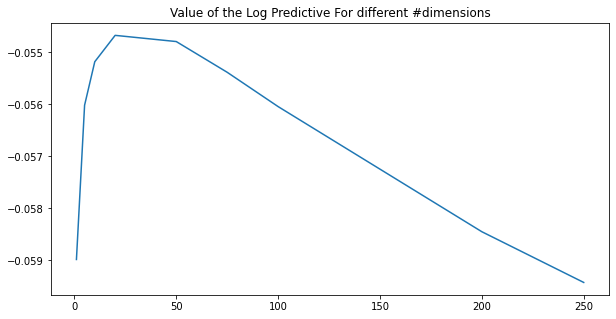

In [32]:
d = [1,5,10,20,50,75,100,200,250]
plt.figure(figsize=(10, 5))
plt.plot(d, s)
plt.title("Value of the Log Predictive For different #dimensions")
#plt.savefig("predictive_score_simple.png")
plt.show()
pyro.clear_param_store()

In [35]:
pyro.clear_param_store()

test2 =  PMF_intercepts(data, train=data, dim=25)
a = test2.train_SVI(data, ~torch.from_numpy(nan_mask)) 



Elbo loss: 535897643.9051666
Elbo loss: 106266668.67115402
Elbo loss: 46923416.74790573
Elbo loss: 33018053.198041916
Elbo loss: 29623132.445438385
Elbo loss: 28305225.496932983
Elbo loss: 27392135.265335083
Elbo loss: 25827996.361613274
Elbo loss: 24398085.06455612
Elbo loss: 22838765.868917465
Elbo loss: 21973058.362236023
Elbo loss: 21483977.135287285
Elbo loss: 21049870.5797987
Elbo loss: 20595638.777591705
Elbo loss: 20447814.031578064
Elbo loss: 20124147.40799904
Elbo loss: 20194609.610042572
Elbo loss: 19995869.338329315
Elbo loss: 19528904.035816193
Elbo loss: 19188491.97726059
Elbo loss: 19498260.293132782
Elbo loss: 19352303.830368042
Elbo loss: 19566615.492076874
Elbo loss: 19138287.57461548
Elbo loss: 19126688.086787224
Elbo loss: 19438389.62813568
Elbo loss: 18997551.598622322
Elbo loss: 19038562.672337532
Elbo loss: 18848205.457401276
Elbo loss: 18693746.337495804
Elbo loss: 19151756.279880524
Elbo loss: 18712068.833515167
Elbo loss: 18621982.266817093
Elbo loss: 18429849

In [34]:
b = test2.train_SVI(data, ~torch.from_numpy(nan_mask) , nsteps=500 )

Elbo loss: 19384790.55083847
Elbo loss: 20010197.01184082
Elbo loss: 19392034.979450226
Elbo loss: 19187731.41849518
Elbo loss: 19485263.09552765
Elbo loss: 19347332.350975037
Elbo loss: 19198893.50935173
Elbo loss: 19301875.003372192


ValueError: Error while computing score_parts at site 'UAint':
Expected value argument (Tensor of shape (1127,)) to be within the support (GreaterThan(lower_bound=0.0)) of the distribution HalfNormal(), but found invalid values:
tensor([2.9239e+11, 1.7663e+11, 3.7070e+11,  ..., 3.3300e+11, 9.9529e+11,
        3.4251e+11], grad_fn=<AbsBackward0>)
Trace Shapes:             
 Param Sites:             
      d_alpha 1127   20   
       d_beta 1127   20   
      s_alpha 5237   20   
       s_beta 5237   20   
      sef_int      5237   
   drug_int_p      1127   
Sample Sites:             
      UA dist 1127    | 20
        value 1127    | 20
     log_prob 1127    |   
   UAint dist 1127    |   
        value 1127    |   

In [36]:
test2.sample_predict(250)

UA: (250, 1, 1127, 25)
drug_int: (250, 1, 1127)
sf_int: (250, 1, 5237)
VA: (250, 1, 5237, 25)
target: (250, 1127, 5237)


In [37]:
#test rmse
test2.rmse(data, nan_mask,1)
#train rmse
test2.rmse(data, ~nan_mask,1)


PMF  RMSE:  0.3775303588714765
AUC: 0.82903
PMF  RMSE:  0.37387566794995664
AUC: 0.83198


(0.37387566794995664, 0.8319824323231667)

In [38]:
#test rmse
test2.rmse(data, nan_mask,4)
#train rmse
test2.rmse(data, ~nan_mask,4)


PMF  RMSE:  0.2935781208202841
AUC: 0.50000
PMF  RMSE:  0.29386885556227027
AUC: 0.50000


(0.29386885556227027, 0.5)